In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Functions for loading valiation (ground truth) models

#Load simpler MPRA-DragoNN conv network (published model from Kundaje Lab)
def get_mpradragonn_smaller_predict_func() :
    
    mpradragonn_smaller = Sequential()

    mpradragonn_smaller.add(Conv1D(120, 5, activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
    mpradragonn_smaller.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
    mpradragonn_smaller.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

    mpradragonn_smaller.add(Conv1D(120, 5, activation='relu', name='dragonn_conv1d_2_copy'))
    mpradragonn_smaller.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
    mpradragonn_smaller.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

    mpradragonn_smaller.add(Conv1D(120, 5, activation='relu', name='dragonn_conv1d_3_copy'))
    mpradragonn_smaller.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
    mpradragonn_smaller.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

    mpradragonn_smaller.add(Flatten())
    mpradragonn_smaller.add(Dense(12, activation='linear', name='dragonn_dense_1_copy'))

    mpradragonn_smaller.compile(
        loss= "mean_squared_error",
        optimizer=keras.optimizers.SGD(lr=0.1)
    )

    model_path = '../pretrained_conv_model.hdf5'

    mpradragonn_smaller.load_weights(model_path)
    
    def _predict_func(seqs, onehots, mpradragonn_smaller=mpradragonn_smaller) :
        
        gt_score = mpradragonn_smaller.predict(x=[onehots])[:, 5]
        
        return gt_score
    
    return _predict_func

#Load linear k-mer model
def get_linear_predict_func() :
    
    sparse_mer2_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=2, count_n_mers=True))
    sparse_mer3_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=3, count_n_mers=True))
    sparse_mer4_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=4, count_n_mers=True))
    sparse_mer5_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=5, count_n_mers=True))
    sparse_mer6_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=6, count_n_mers=True))
    sparse_mer7_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=7, count_n_mers=True))
    sparse_mer8_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=8, count_n_mers=True))
    
    l2_alpha = 2000.0
    
    nonzero_feat_ix = pickle.load(open("mpradragonn_mer2345678_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["nonzero_feat_ix"]
    linear_model = pickle.load(open("mpradragonn_mer2345678_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["mer6_linear"]
    
    def _predict_func(seqs, onehots, linear_model=linear_model, nonzero_feat_ix=nonzero_feat_ix) :
        
        mer2 = sparse_mer2_encoder(seqs)
        mer3 = sparse_mer3_encoder(seqs)
        mer4 = sparse_mer4_encoder(seqs)
        mer5 = sparse_mer5_encoder(seqs)
        mer6 = sparse_mer6_encoder(seqs)
        mer7 = sparse_mer7_encoder(seqs)
        mer8 = sparse_mer8_encoder(seqs)

        mer = sp.csr_matrix(sp.hstack([
            mer2,
            mer3,
            mer4,
            mer5,
            mer6,
            mer7,
            mer8,
        ]))

        log_mer = sp.coo_matrix(mer.copy())
        log_mer.data = np.log2(1. + log_mer.data)
        log_mer = sp.csr_matrix(log_mer)
        
        gt_score = linear_model.predict(log_mer[:, nonzero_feat_ix])
        
        return gt_score
    
    return _predict_func

#Load boosted k-mer model
def get_boosted_predict_func() :
    
    sparse_mer2_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=2, count_n_mers=True))
    sparse_mer3_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=3, count_n_mers=True))
    sparse_mer4_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=4, count_n_mers=True))
    sparse_mer5_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=5, count_n_mers=True))
    sparse_mer6_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=6, count_n_mers=True))
    sparse_mer7_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=7, count_n_mers=True))
    sparse_mer8_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=8, count_n_mers=True))
    
    n_estimators = 256
    max_depth = 5
    
    #Linear model from which we collect the kept feature index
    linear_model_l2_alpha = 2000.0
    
    nonzero_feat_ix = pickle.load(open("mpradragonn_mer2345678_linear_l2_alpha_" + str(linear_model_l2_alpha).replace(".", "_") + ".pickle", "rb"))["nonzero_feat_ix"]
    boosted_model = pickle.load(open("mpradragonn_mer2345678_boosted_grad_n_estimators_" + str(n_estimators) + "_max_depth_" + str(max_depth) + "_n_features_" + str(len(nonzero_feat_ix)) + ".pickle", "rb"))["boosted_grad"]
    
    def _predict_func(seqs, onehots, boosted_model=boosted_model, nonzero_feat_ix=nonzero_feat_ix) :
        
        mer2 = sparse_mer2_encoder(seqs)
        mer3 = sparse_mer3_encoder(seqs)
        mer4 = sparse_mer4_encoder(seqs)
        mer5 = sparse_mer5_encoder(seqs)
        mer6 = sparse_mer6_encoder(seqs)
        mer7 = sparse_mer7_encoder(seqs)
        mer8 = sparse_mer8_encoder(seqs)

        mer = sp.csr_matrix(sp.hstack([
            mer2,
            mer3,
            mer4,
            mer5,
            mer6,
            mer7,
            mer8,
        ]))

        log_mer = sp.coo_matrix(mer.copy())
        log_mer.data = np.log2(1. + log_mer.data)
        log_mer = sp.csr_matrix(log_mer)
        
        gt_score = boosted_model.predict(log_mer[:, nonzero_feat_ix])
        
        return gt_score
    
    return _predict_func


In [3]:
#Initialize validation model predict functions

gt_predict_funcs = [
    get_mpradragonn_smaller_predict_func(),
    get_linear_predict_func(),
    get_boosted_predict_func()
]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
#Load and predict sequence trajectory data

#Metric helper functions
def compute_ground_truths(seqs, onehots, gt_predict_funcs=gt_predict_funcs, seq_start=0, seq_end=145, n_samples=50) :
    n_samples = min(n_samples, onehots.shape[0])
    
    shuffle_index = np.arange(onehots.shape[0])
    np.random.shuffle(shuffle_index)
    
    seqs = [seqs[k][seq_start:seq_end] for k in shuffle_index[:n_samples].tolist()]
    onehots = onehots[shuffle_index[:n_samples], seq_start:seq_end, :, 0]
    
    gt_scores = []
    for i in range(len(gt_predict_funcs)) :
        gt_scores.append(gt_predict_funcs[i](seqs, onehots))
    
    return gt_scores

def compute_within_edit_distance(onehots, opt_len=54) :
    shuffle_index = np.arange(onehots.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)
    
    seqs = [acgt_encoder.decode(onehots[i, :, :, 0]) for i in range(onehots.shape[0])]
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(onehots.shape[0])]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    edit_distances /= opt_len
    
    mean_edit_distance = np.mean(edit_distances)
    
    return edit_distances, mean_edit_distance

def compute_metrics(seqs, x_test, n_seqs_to_test=960, batch_size=64, seq_start=0, seq_end=145, opt_len=145) :
    
    onehots = np.expand_dims(np.concatenate([
        np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
    ], axis=0), axis=-1)

    #Predict fitness
    score_pred = saved_predictor.predict(x=[onehots[:n_seqs_to_test, :, :, 0]], batch_size=batch_size)[:, 5]
    
    scores_true = compute_ground_truths(seqs, onehots, seq_start=seq_start, seq_end=seq_end)
    
    #Compare pair-wise edit distances
    within_edit_dists, _ = compute_within_edit_distance(onehots[:n_seqs_to_test], opt_len=opt_len)
    
    return score_pred, scores_true, within_edit_dists

def load_and_aggregate_score(file_path, x_test, agg_mode='perc', agg_perc=50, split_on_tab=True, seq_template=None, predictor=None, batch_size=32, max_n_sequences=960) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if seq_template is not None :
                    seq = ''.join([
                        seq_template[j] if seq_template[j] != 'N' else seq[j]
                        for j in range(len(seq))
                    ])

                seqs.append(seq)
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        seq_start = [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))].index(1)
        seq_end = len(seq_template) - [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))][::-1].index(1)
        
        def _comp_metrics(_seqs, _x) :
            return compute_metrics(
                _seqs,
                _x,
                n_seqs_to_test=len(_seqs),
                batch_size=batch_size,
                seq_start=seq_start,
                seq_end=seq_end,
                opt_len=np.sum([1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))])
            )
        
        score_pred, scores_true, within_edit_dists = _comp_metrics(seqs, x_test)
        
        score_pred_agg = np.percentile(score_pred, agg_perc)
        if agg_mode == 'mean' :
            score_pred_agg = np.mean(score_pred)
        
        scores_true_agg = []
        for k in range(len(scores_true)) :
            score_true_agg = np.percentile(scores_true[k], agg_perc)
            if agg_mode == 'mean' :
                score_true_agg = np.mean(scores_true[k])
            
            scores_true_agg.append(score_true_agg)
        
        edit_dist_agg = np.percentile(within_edit_dists, agg_perc)
        if agg_mode == 'mean' :
            edit_dist_agg = np.mean(within_edit_dists)
        
        return score_pred_agg, edit_dist_agg, scores_true_agg
    
    except FileNotFoundError :
        return np.nan, np.nan, []

def load_sequences(file_path, pick_every=1, split_on_tab=True, seq_template=None, max_n_sequences=50) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            i = 0
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if i % pick_every == 0 :
                    seqs.append(seq)
                
                i += 1
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        seq_start = [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))].index(1)
        seq_end = len(seq_template) - [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))][::-1].index(1)
        
        def _comp_metrics(_seqs) :
            return compute_metrics(
                _seqs,
                None,
                n_seqs_to_test=len(_seqs),
                batch_size=1,
                seq_start=seq_start,
                seq_end=seq_end,
                opt_len=np.sum([1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))])
            )
        
        score_pred, scores_true, _ = _comp_metrics(seqs)
        
        preds = [score_pred] + scores_true
        
        return seqs, preds
    
    except FileNotFoundError :
        return [], []


In [5]:
#Create encoder
acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})


In [6]:
#Load cached dataframe

x_test = None


In [7]:
#Load predictor

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

def _load_mpradragonn_func(model_path) :

    saved_model = Sequential()

    # sublayer 1
    saved_model.add(Conv1D(48, 3, padding='same', activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

    saved_model.add(Conv1D(64, 3, padding='same', activation='relu', name='dragonn_conv1d_2_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

    saved_model.add(Conv1D(100, 3, padding='same', activation='relu', name='dragonn_conv1d_3_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

    saved_model.add(Conv1D(150, 7, padding='same', activation='relu', name='dragonn_conv1d_4_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_4_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_4_copy'))

    saved_model.add(Conv1D(300, 7, padding='same', activation='relu', name='dragonn_conv1d_5_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_5_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_5_copy'))

    saved_model.add(MaxPooling1D(3))

    # sublayer 2
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_6_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_6_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_6_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_7_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_7_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_7_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_8_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_8_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_8_copy'))

    saved_model.add(MaxPooling1D(4))

    # sublayer 3
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_9_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_9_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_9_copy'))

    saved_model.add(MaxPooling1D(4))

    saved_model.add(Flatten())
    saved_model.add(Dense(100, activation='relu', name='dragonn_dense_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_10_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_10_copy'))
    saved_model.add(Dense(12, activation='linear', name='dragonn_dense_2_copy'))

    saved_model.compile(
        loss= "mean_squared_error",
        optimizer=keras.optimizers.SGD(lr=0.1)
    )

    saved_model.load_weights(model_path)
    
    return saved_model

predictor_path = '../pretrained_deep_factorized_model.hdf5'

saved_predictor = _load_mpradragonn_func(predictor_path)


In [8]:
#Trajectory comparison configuration

sequence_template = "N" * 145

traj_dirs = [
    "killoran",
    "fbvae/mpradragonn_fb_vae_epochs_50_kl_factor_05_iters_150_samples_1000_q_06",
    "cbas/mpradragonn_cbas_vae_epochs_50_kl_factor_05_iters_150_samples_1000_q_06_yt_scale_002_alpha_1_it_epochs_1",
    "cbas/mpradragonn_rwr_vae_epochs_50_kl_factor_05_iters_150_samples_1000_q_06_yt_scale_002_alpha_1_it_epochs_10",
    "../../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60",
    "../../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_80",
    "../seqprop_samples/seqprop_mpdradragonn_max_activity_20000_updates_non_normalized",
    "../seqprop_samples/seqprop_mpdradragonn_max_activity_20000_updates",
    "../seqprop_samples/seqprop_mpdradragonn_max_activity_20000_updates_elbo"
]

traj_file_funcs = [
    lambda i: "killoran_vae_epochs_50_kl_factor_05_mpradragonn_seqs_iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt"
]

traj_scalefuncs = [
    lambda i: i * 1,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 960,
    lambda i: i * 960,
    lambda i: i * 1,
    lambda i: i * 1,
    lambda i: i * 1
]

traj_names = [
    "AM-VAE (2000 Iters)",
    "FB-VAE (qt = .6)",
    "CBAS (qt = .6)",
    "RWR (qt = .6, alpha = 1)",
    "FB-GAN (qt = .6)",
    "FB-GAN (qt = .8)",
    "Sampled",
    "Sampled-IN",
    "Sampled-IN-VAE"
]

file_indexes = [
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000],#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000]#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
]

traj_repeat_suffixes = [
    [""],
    ["", "_retry_1", "_retry_2"],
    ["_run_0", "_run_1", "_run_2"],
    ["_run_0", "_run_1", "_run_2"],
    [""],
    [""],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"]
]


In [ ]:
#Compute trajectories

repeat_agg_mode = 'median'

model_trajs = []
model_iters = []
model_scores = []

for model_i in range(len(traj_dirs)) :
    traj = []
    iter_scale = []
    
    last_file_i = -1
    
    for file_i in file_indexes[model_i] :
        
        y_vals_repeats = []
        
        for repeat_suffix in traj_repeat_suffixes[model_i] :
            y_vals = load_and_aggregate_score(
                traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](file_i),
                x_test=x_test,
                seq_template=sequence_template,
                predictor=saved_predictor,
                batch_size=32,
                max_n_sequences=100,
                agg_mode='perc',
                agg_perc=50
            )

            if len(y_vals[2]) == 0 :
                y_vals = (y_vals[0], y_vals[1], [np.nan] * (len(traj[0]) - 2))
            else :
                last_file_i = file_i
            
            y_vals = np.array([y_vals[0], y_vals[1]] + y_vals[2]).reshape(-1, 1)
            y_vals_repeats.append(y_vals)
        
        y_vals_repeats = np.concatenate(y_vals_repeats, axis=1)
        y_vals = np.median(y_vals_repeats, axis=1)
        if repeat_agg_mode == 'mean' :
            y_vals = np.mean(y_vals_repeats, axis=1)

        traj.append(y_vals)
        iter_scale.append(traj_scalefuncs[model_i](file_i))
    
    #Load final scores
    final_scores_repeats = []
    for repeat_suffix in traj_repeat_suffixes[model_i] :
        _, final_scores = load_sequences(traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](last_file_i), seq_template=sequence_template, max_n_sequences=10)
        final_scores = np.concatenate([final_score.reshape(-1, 1) for final_score in final_scores], axis=-1)
        final_scores_repeats.append(final_scores)
    
    final_scores_repeats = np.concatenate(final_scores_repeats, axis=0)

    model_scores.append(final_scores_repeats)
    
    traj = np.array(traj)
    iter_scale = np.array(iter_scale)
    
    model_trajs.append(traj)
    model_iters.append(iter_scale)


In [10]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

def plot_trajectories(iterations, measures, model_names, add_zeros, measure_ix, x_label, y_label, rolling_window=1, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=300, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    
    f = plt.figure(figsize=figsize)
    
    max_iter_val = 0
    
    ls = []
    for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :
        all_meas = all_meas.T
        
        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]
        
        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]
        
        if add_zeros[model_ix] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[model_ix]]), meas], axis=0)
        
        if log10_scale :
            iters_copy[1:] = np.log10(iters_copy[1:])
        
        max_iter_val = max(max_iter_val, np.max(iters_copy))
        
        meas = _rolling_average(meas, window=rolling_window)
        
        l1 = None
        if colors is not None :
            l1 = plt.plot(iters_copy, meas, color=colors[model_ix], linewidth=2, label=model_names[model_ix])
        else :
            l1 = plt.plot(iters_copy, meas, linewidth=2, label=model_names[model_ix])
        
        ls.append(l1[0])

    if log10_scale :
        plt.xticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14)
    else :
        plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(min_x_val, max_x_val)
    else :
        plt.xlim(min_x_val, max_iter_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(handles=ls, fontsize=14, loc='upper left')
    else :
        plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


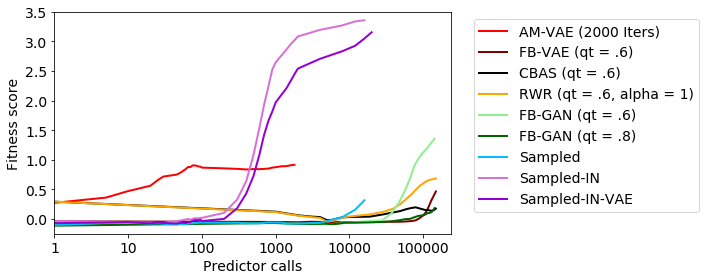

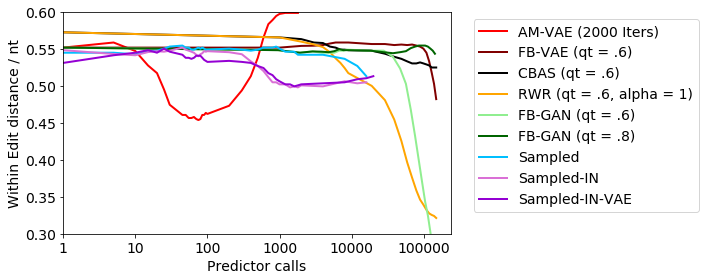

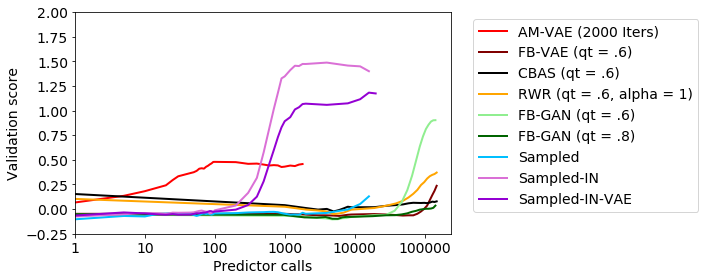

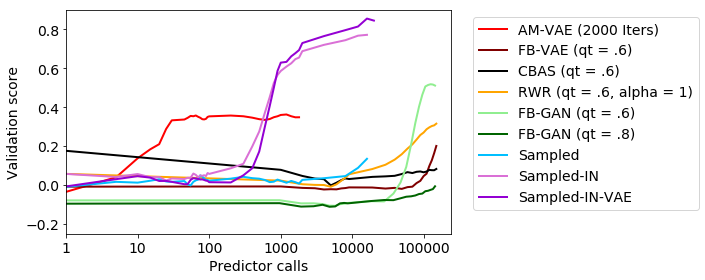

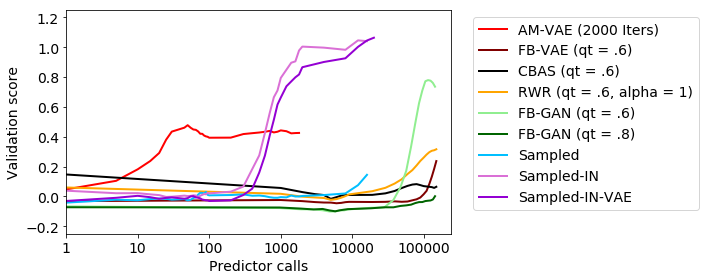

In [12]:
#Plot trajectory data

problem_prefix = "benchmark_mpradragonn"

experiment_suffix = "_traj_comparisons_log"

model_colors = ['red', 'maroon', 'black', 'orange', 'lightgreen', 'darkgreen', 'deepskyblue', 'orchid', 'darkviolet', 'indigo']

figsize = (10, 4)

save_figs = True

predictor_min_y_val = [-0.25, -0.25]
predictor_max_y_val = [3.5, 4.0]

n_gt_predictors = 3

gt_predictor_min_y_vals = [
    [-0.25, -0.25, -0.25],
    [-0.25, -0.25, -0.25]
]

gt_predictor_max_y_vals = [
    [2.0, 0.9, 1.25],
    [2.2, 1.0, 1.4]
]

rolling_window = 5

plot_trajectories(
    model_iters,
    model_trajs,
    traj_names,
    [None, None, None, None, None, None, None, None, None, None],
    0,
    'Predictor calls',
    'Fitness score',
    rolling_window=rolling_window,
    colors=model_colors,
    min_x_val=0,
    max_x_val=None,
    min_y_val=predictor_min_y_val[0],
    max_y_val=predictor_max_y_val[0],
    figsize=figsize,
    save_fig=save_figs,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log",
    legend_outside=True,
    log10_scale=True
)

plot_trajectories(
    model_iters,
    model_trajs,
    traj_names,
    [None, None, None, None, None, None, None, None, None, None],
    1,
    'Predictor calls',
    'Within Edit distance / nt',
    rolling_window=rolling_window,
    colors=model_colors,
    min_x_val=0,
    max_x_val=None,
    min_y_val=0.3,
    max_y_val=0.6,
    figsize=figsize,
    save_fig=save_figs,
    fig_name=problem_prefix + experiment_suffix + "_within_edit_distance_log",
    legend_outside=True,
    log10_scale=True
)

for gt_predictor_ix in range(n_gt_predictors) :
    plot_trajectories(
        model_iters,
        model_trajs,
        traj_names,
        [None, None, None, None, None, None, None, None, None, None],
        2 + gt_predictor_ix,
        'Predictor calls',
        'Validation score',
        rolling_window=rolling_window,
        colors=model_colors,
        min_x_val=0,
        max_x_val=None,
        min_y_val=gt_predictor_min_y_vals[0][gt_predictor_ix],
        max_y_val=gt_predictor_max_y_vals[0][gt_predictor_ix],
        figsize=figsize,
        save_fig=save_figs,
        fig_name=problem_prefix + experiment_suffix + "_validation_" + str(gt_predictor_ix) + "_log",
        legend_outside=True,
        log10_scale=True
    )
